### Model Building 

In [23]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Layer,Dense, Input, LSTM,Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, Add, RepeatVector, TimeDistributed,concatenate
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import regularizers
#from tensorflow.compact.v1.keras.layers import Attention
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
df = pd.read_excel('/content/drive/My Drive/D5.1(InputData)_processed_trimmed_data_all_columns.xlsx',sheet_name='Sheet1',encoding="utf-8",dtype="str")

In [29]:
#df = df[df["email_type"]!="monitoring_tool"]
#df = df[df["Assignment group"]!="GRP_0"]
#df = df[df["new_group_75"]!="GRP_9999"]


In [30]:
df = df[["trimmed_words_short",
          "trimmed_words_long","Caller","email_type",
         "Assignment group",
         "new_group_75",
         "new_group_85",
         "new_group_95",
         "flg_account_related",
         "flg_crm",
         "flg_engineering",
         "flg_erp",
         "flg_failed","flg_help","flg_install",
        "flg_job","flg_laptop","flg_mobile",
        "flg_network","flg_outlook",
        "flg_printer","flg_skype",
        "flg_ticket_update","flg_vpn",
        "flg_windows","host_related",
        "blank_call","setup_ws"
]]

In [31]:
df_features = df[["flg_account_related",
         "flg_crm",
         "flg_engineering",
         "flg_erp",
         "flg_failed","flg_help","flg_install",
        "flg_job","flg_laptop","flg_mobile",
        "flg_network","flg_outlook",
        "flg_printer","flg_skype",
        "flg_ticket_update","flg_vpn",
        "flg_windows","host_related",
        "blank_call","setup_ws"
]]

In [32]:
df["new_group_56"] = df["new_group_75"].apply(lambda x: "GRP_0" if x == "GRP_8" 
                                              else ("GRP_0" if x=="GRP_0" else "GRP_L3"))

df1 = df[df["new_group_56"]!="GRP_0"]
#df1 = df[df["new_group_56"]!="GRP_9999"]

In [33]:
df["new_group_75"].value_counts()

GRP_0       3954
GRP_9999    2122
GRP_8        661
GRP_24       289
GRP_12       257
GRP_9        252
GRP_2        241
GRP_19       213
GRP_3        200
GRP_6        184
Name: new_group_75, dtype: int64

In [34]:
df["new_group_56"].value_counts()

GRP_0     4615
GRP_L3    3758
Name: new_group_56, dtype: int64

In [35]:
maxlen_s = 30
maxlen_l = 70
maxlen_combo = 100
embedding_size = 200
numword1 = 2000
numword2 = 2000
numword3 = 3000

In [36]:
def prepare_token(data,numword):
  t = Tokenizer(num_words=numword)
  t.fit_on_texts(data)
  print("Tokenization process...F1.2..", len(t.word_index)) 
  return (t)

In [37]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [38]:
def Glv_model(data,t):
  #print("Preparing GloVe vector...F1.3 .. token as input", len(t.word_index))
  embeddings = {}  
  if len(embeddings)==0:
    EMBEDDING_FILE = '/content/drive/My Drive/AIML_Project_Files_Final/glove.6B.200d.txt'
    embeddings = dict()
    f = open(EMBEDDING_FILE,encoding='Latin-1')
    for line in (f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings[word] = coefs
    f.close()
  print("Glove being used:",len(embeddings))
  
  word_index = t.word_index
  print("t.word_index shape", len(t.word_index))  
  embedding_matrix = np.zeros((t.num_words, embedding_size))
  #print("Embedding Matrix Shape : ", embedding_matrix.shape )
  for word, i in tqdm(word_index.items()):
    if i < t.num_words:
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            #if i < 2 : print(i,embedding_matrix[i])
  return(embedding_matrix)

In [39]:
#Tokenization and Embedding Process

t1 = prepare_token(df["trimmed_words_short"],numword1)
t2 = prepare_token(df["trimmed_words_long"],numword2)
t3 = prepare_token(df["Caller"]+" "+df["trimmed_words_short"]+" "+df["trimmed_words_long"],numword3)

embedding_matrix1 = Glv_model(df["trimmed_words_short"],t1)
embedding_matrix2 = Glv_model(df["trimmed_words_long"],t2)
embedding_matrix3 = Glv_model(df["trimmed_words_short"]+" "+df["trimmed_words_long"],t3)



Tokenization process...F1.2.. 5809
Tokenization process...F1.2.. 12988
Tokenization process...F1.2.. 18440


100%|██████████| 5809/5809 [00:00<00:00, 45877.75it/s]

Glove being used: 399955
t.word_index shape 5809



100%|██████████| 12988/12988 [00:00<00:00, 93714.89it/s]

Glove being used: 399955
t.word_index shape 12988



100%|██████████| 18440/18440 [00:00<00:00, 105036.74it/s]

Glove being used: 399955
t.word_index shape 18440


In [40]:
len(df["trimmed_words_short"]+" "+df["trimmed_words_long"])

8373

In [41]:
print(t1.num_words)
print(len(t1.word_counts))
print(t2.num_words)
print(len(t2.word_counts))
print(t3.num_words)
print(len(t3.word_counts))



2000
5809
2000
12988
3000
18440


In [42]:
oversample = SMOTE()
undersample = NearMiss()
## Data Preparation
X_short_t = t3.texts_to_sequences(df["trimmed_words_short"])
X_long_t = t3.texts_to_sequences(df["trimmed_words_long"])
X_combo_t = t3.texts_to_sequences(df["Caller"]+" "+df["trimmed_words_short"]+" "+df["trimmed_words_long"])
X_features = np.array(df_features)

X_short = pad_sequences(X_short_t, maxlen=maxlen_s, padding = 'post', truncating = 'post')
X_long = pad_sequences(X_long_t, maxlen=maxlen_l, padding = 'post', truncating = 'post')
X_combo = pad_sequences(X_combo_t,maxlen= maxlen_combo, padding = 'post', truncating='post')

#X_short_u,y_u = undersample.fit_resample(X_short,df["new_group_75"])
#X_short_o,y_o = oversample.fit_resample(X_short,df["new_group_75"])

onehot_encoder1 = OneHotEncoder(sparse=False)
y = onehot_encoder1.fit_transform(np.array(df["Assignment group"]).reshape(len(df["Assignment group"]),1))
onehot_encoder2 = OneHotEncoder(sparse=False)
y_75 = onehot_encoder2.fit_transform(np.array(df["new_group_75"]).reshape(len(df["new_group_75"]),1))
onehot_encoder3 = OneHotEncoder(sparse=False)
y_85 = onehot_encoder3.fit_transform(np.array(df["new_group_85"]).reshape(len(df["new_group_85"]),1))
onehot_encoder4 = OneHotEncoder(sparse=False)
y_95 = onehot_encoder4.fit_transform(np.array(df["new_group_95"]).reshape(len(df["new_group_95"]),1))
#onehot_encoder5 = OneHotEncoder(sparse=False)
#y_55 = onehot_encoder5.fit_transform(np.array(df["new_group_55"]).reshape(len(df["new_group_55"]),1))
onehot_encoder6 = OneHotEncoder(sparse=False)
y_56 = onehot_encoder6.fit_transform(np.array(df["new_group_56"]).reshape(len(df["new_group_56"]),1))


Groups = len(df["Assignment group"].value_counts())
Groups_75 = len(df["new_group_75"].value_counts())
Groups_85 = len(df["new_group_85"].value_counts())
Groups_95 = len(df["new_group_95"].value_counts())

# Split features into training and validation sets
#X_train_s, X_val_s, X_train_l,X_val_l,X_train_combo,X_val_combo, y_train, y_val,y_train_75,y_val_75,y_train_85,y_val_85,y_train_95,y_val_95,y_train_55,y_val_55,y_train_56,y_val_56 = train_test_split(X_short,X_long,X_combo,y,y_75,y_85,y_95,y_55,y_56, test_size=0.20, random_state=15)
X_train_s, X_val_s, X_train_l,X_val_l,X_train_combo,X_val_combo,X_train_features,X_val_features, y_train, y_val,y_train_75,y_val_75,y_train_85,y_val_85,y_train_95,y_val_95,y_train_56,y_val_56 = train_test_split(X_short,X_long,X_combo,X_features,y,y_75,y_85,y_95,y_56, test_size=0.20, random_state=15)

print("X_train_s Shape : ",X_train_s.shape)
print("X_train_l Shape : ",X_train_l.shape)
print("X_train_combo Shape : ",X_train_combo.shape)

print("y_train Shape : ",y_train.shape)
print("Group counts : ",Groups,Groups_75,Groups_85,Groups_95)


X_train_s Shape :  (6698, 30)
X_train_l Shape :  (6698, 70)
X_train_combo Shape :  (6698, 100)
y_train Shape :  (6698, 74)
Group counts :  74 10 18 36


In [43]:
df["new_group_56"].value_counts()

GRP_0     4615
GRP_L3    3758
Name: new_group_56, dtype: int64

In [44]:
# Build the Model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Model with Short description..............
short_desc_input = Input(shape=(maxlen_s,), dtype='int32',name = "1.0_Input_Layer")
print(short_desc_input)
embedded_sequences = Embedding(t3.num_words, embedding_size,weights = [embedding_matrix3], trainable = True, name='1.1_Embedding')(short_desc_input)
short_lstm = Bidirectional(LSTM(100, return_sequences=True, dropout=0.2,recurrent_dropout=0.2),name = "1.2_Bidirectional")(embedded_sequences)
#attn = attention()(short_lstm)
short_dense = TimeDistributed(Dense(50),name = "1.3_TimeDense")(short_lstm)
#attn = attention(name = "1.4_attention")(short_dense)
dropout1 = Dropout(0.3)(short_dense)
short_flatten = Flatten(name="1.5_Flatten")(dropout1)

# Model with Long description..............
long_input = Input(shape=(maxlen_l,), dtype='int32',name = "2.0_Input_Layer")
long_embedded_sequences = Embedding(t3.num_words, embedding_size,weights = [embedding_matrix3], trainable = True, name='2.1_Embedding')(long_input)
long_lstm = Bidirectional(LSTM(100, return_sequences=True, dropout = 0.2, recurrent_dropout=0.2),name = "2.2_Bidirectional")(long_embedded_sequences)
long_dense = Dense(20, activation='relu',name = "2.3_Dense",
                   kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(long_lstm)
dropout2 = Dropout(0.3)(long_dense)
long_flatten = Flatten(name = "2.4_Flatten")(dropout2)

# Model with Features extracted
features_input = Input(shape=(20,), name = "ftrs_Input_layer")
feature_dense = Dense(100, activation='relu',name = "ftrs_Dense")(features_input)

#Concate both the end Layers ....................
description_output = concatenate([short_flatten, long_flatten,feature_dense], name='3.1_concatenate_heading')
dropout3 = Dropout(0.2)(description_output)
description_vector = Dense(50, activation='relu',name = "3.2_Dense",
                          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(dropout3)
preds = Dense(10, activation='softmax',name = "3.3_Dense")(description_vector)

#Final model and compiling.................
model_final = Model([short_desc_input, long_input,features_input], [preds])
model_final.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001), 
                    metrics=['accuracy', 'mse'],experimental_run_tf_function=False)
#model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model_final.summary()  



Tensor("1.0_Input_Layer_1:0", shape=(None, 30), dtype=int32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
1.0_Input_Layer (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
2.0_Input_Layer (InputLayer)    [(None, 70)]         0                                            
__________________________________________________________________________________________________
1.1_Embedding (Embedding)       (None, 30, 200)      600000      1.0_Input_Layer[0][0]            
__________________________________________________________________________________________________
2.1_Embedding (Embedding)       (None, 70, 200)      600000      2.0_Input_Layer[0][0]            
_______________________________

In [45]:
# Run the model....
reduce_lr = (ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=2, min_lr=0.00000001))
early_stop = (EarlyStopping(monitor='val_accuracy', patience= 5))

history = model_final.fit([X_train_s,X_train_l,X_train_features], [y_train_75], 
                    validation_data=[[X_val_s,X_val_l,X_val_features],[y_val_75]], 
                    epochs=100, batch_size=32,callbacks= ([reduce_lr,early_stop]), verbose = 1)

Train on 6698 samples, validate on 1675 samples
Epoch 1/100
6698/6698 [==============================] - 51s 8ms/sample - loss: 2.2072 - accuracy: 0.6042 - mse: 0.0533 - val_loss: 1.4032 - val_accuracy: 0.6561 - val_mse: 0.0457
Epoch 2/100
6698/6698 [==============================] - 46s 7ms/sample - loss: 1.2545 - accuracy: 0.6913 - mse: 0.0426 - val_loss: 1.1398 - val_accuracy: 0.7033 - val_mse: 0.0412
Epoch 3/100
6698/6698 [==============================] - 47s 7ms/sample - loss: 1.0377 - accuracy: 0.7290 - mse: 0.0375 - val_loss: 1.0559 - val_accuracy: 0.7069 - val_mse: 0.0395
Epoch 4/100
6698/6698 [==============================] - 47s 7ms/sample - loss: 0.9081 - accuracy: 0.7581 - mse: 0.0335 - val_loss: 1.0355 - val_accuracy: 0.7116 - val_mse: 0.0387
Epoch 5/100
6698/6698 [==============================] - 49s 7ms/sample - loss: 0.8197 - accuracy: 0.7829 - mse: 0.0303 - val_loss: 1.0108 - val_accuracy: 0.7236 - val_mse: 0.0386
Epoch 6/100
6698/6698 [=============================

In [47]:
y_pred = model_final.predict([X_val_s,X_val_l,X_val_features])

In [52]:
a = np.argmax(y_pred,axis = 1)
b = np.argmax(y_val_75,axis = 1)

In [53]:
from sklearn.metrics import * 

In [54]:
print(confusion_matrix(a,b))

[[719   5  19  15   4  16   0   0   4  82]
 [  7  31   1   1   1   0   0   1   0  10]
 [  8   3  11   0   0   8   0   0   0   4]
 [  4   0   0  19   0   1   0   0   0   8]
 [  2   1   3   0  42   0   0   0   0   0]
 [  4   1   3   0   0   7   0   0   0   3]
 [  0   0   0   0   0   0  15   1   0   0]
 [  0   5   0   0   0   0  17  95  29  28]
 [  2   0   0   0   0   0   2   8   9   4]
 [ 73  14   5  10   2  10   7  11   8 272]]


In [55]:
print(classification_report(a,b))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       864
           1       0.52      0.60      0.55        52
           2       0.26      0.32      0.29        34
           3       0.42      0.59      0.49        32
           4       0.86      0.88      0.87        48
           5       0.17      0.39      0.23        18
           6       0.37      0.94      0.53        16
           7       0.82      0.55      0.66       174
           8       0.18      0.36      0.24        25
           9       0.66      0.66      0.66       412

    accuracy                           0.73      1675
   macro avg       0.51      0.61      0.54      1675
weighted avg       0.76      0.73      0.74      1675



In [56]:
onehot_encoder2.categories_

[array(['GRP_0', 'GRP_12', 'GRP_19', 'GRP_2', 'GRP_24', 'GRP_3', 'GRP_6',
        'GRP_8', 'GRP_9', 'GRP_9999'], dtype=object)]

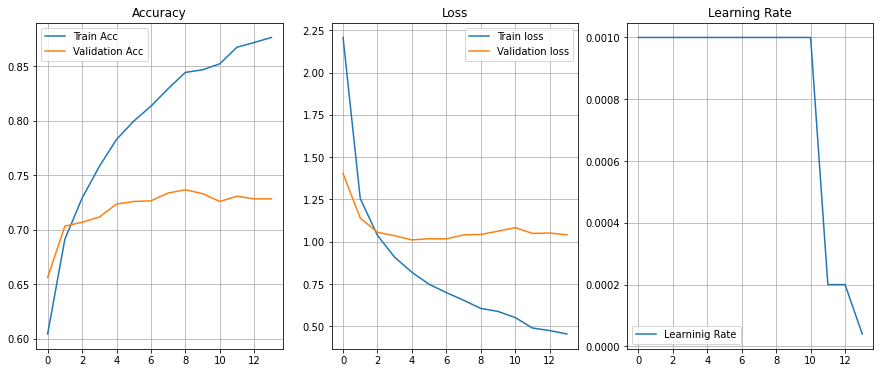

In [58]:
fig = plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
#print("\n Data set : "+D+" & "+T+";  No of Output Groups: "+str(Groups)+" ; GloVe vector used : "+glv+"; Attention :"+attention1)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(history.history['lr'], label='Learninig Rate')
plt.title("Learning Rate")
plt.legend()
plt.grid()


plt.show()

In [60]:
# Building the same model with Glove embedding trainable as False
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Model with Short description..............
short_desc_input = Input(shape=(maxlen_s,), dtype='int32',name = "1.0_Input_Layer")
print(short_desc_input)
embedded_sequences = Embedding(t3.num_words, embedding_size,weights = [embedding_matrix3], trainable = False, name='1.1_Embedding')(short_desc_input)
short_lstm = Bidirectional(LSTM(100, return_sequences=True, dropout=0.2,recurrent_dropout=0.2),name = "1.2_Bidirectional")(embedded_sequences)
#attn = attention()(short_lstm)
short_dense = TimeDistributed(Dense(50),name = "1.3_TimeDense")(short_lstm)
#attn = attention(name = "1.4_attention")(short_dense)
dropout1 = Dropout(0.3)(short_dense)
short_flatten = Flatten(name="1.5_Flatten")(dropout1)

# Model with Long description..............
long_input = Input(shape=(maxlen_l,), dtype='int32',name = "2.0_Input_Layer")
long_embedded_sequences = Embedding(t3.num_words, embedding_size,weights = [embedding_matrix3], trainable = False, name='2.1_Embedding')(long_input)
long_lstm = Bidirectional(LSTM(100, return_sequences=True, dropout = 0.2, recurrent_dropout=0.2),name = "2.2_Bidirectional")(long_embedded_sequences)
long_dense = Dense(20, activation='relu',name = "2.3_Dense",
                   kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(long_lstm)
dropout2 = Dropout(0.3)(long_dense)
long_flatten = Flatten(name = "2.4_Flatten")(dropout2)

# Model with Features extracted
features_input = Input(shape=(20,), name = "ftrs_Input_layer")
feature_dense = Dense(100, activation='relu',name = "ftrs_Dense")(features_input)

#Concate both the end Layers ....................
description_output = concatenate([short_flatten, long_flatten,feature_dense], name='3.1_concatenate_heading')
dropout3 = Dropout(0.2)(description_output)
description_vector = Dense(50, activation='relu',name = "3.2_Dense",
                          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(dropout3)
preds = Dense(10, activation='softmax',name = "3.3_Dense")(description_vector)

#Final model and compiling.................
model_final = Model([short_desc_input, long_input,features_input], [preds])
model_final.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001), 
                    metrics=['accuracy', 'mse'],experimental_run_tf_function=False)
#model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model_final.summary()  

Tensor("1.0_Input_Layer_3:0", shape=(None, 30), dtype=int32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
1.0_Input_Layer (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
2.0_Input_Layer (InputLayer)    [(None, 70)]         0                                            
__________________________________________________________________________________________________
1.1_Embedding (Embedding)       (None, 30, 200)      600000      1.0_Input_Layer[0][0]            
__________________________________________________________________________________________________
2.1_Embedding (Embedding)       (None, 70, 200)      600000      2.0_Input_Layer[0][0]            
_______________________________

In [63]:
# Run the model....
reduce_lr = (ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=2, min_lr=0.00000001))
early_stop = (EarlyStopping(monitor='val_accuracy', patience= 15))

history = model_final.fit([X_train_s,X_train_l,X_train_features], [y_train_75], 
                    validation_data=[[X_val_s,X_val_l,X_val_features],[y_val_75]], 
                    epochs=100, batch_size=32,callbacks= ([reduce_lr,early_stop]), verbose = 1)

Train on 6698 samples, validate on 1675 samples
Epoch 1/100
6698/6698 [==============================] - 44s 7ms/sample - loss: 2.3545 - accuracy: 0.5744 - mse: 0.0569 - val_loss: 1.5879 - val_accuracy: 0.6418 - val_mse: 0.0494
Epoch 2/100
6698/6698 [==============================] - 36s 5ms/sample - loss: 1.4230 - accuracy: 0.6390 - mse: 0.0489 - val_loss: 1.3192 - val_accuracy: 0.6424 - val_mse: 0.0478
Epoch 3/100
6698/6698 [==============================] - 39s 6ms/sample - loss: 1.2334 - accuracy: 0.6608 - mse: 0.0460 - val_loss: 1.1864 - val_accuracy: 0.6710 - val_mse: 0.0453
Epoch 4/100
6698/6698 [==============================] - 40s 6ms/sample - loss: 1.1353 - accuracy: 0.6804 - mse: 0.0443 - val_loss: 1.1484 - val_accuracy: 0.6657 - val_mse: 0.0453
Epoch 5/100
6698/6698 [==============================] - 39s 6ms/sample - loss: 1.0802 - accuracy: 0.6844 - mse: 0.0432 - val_loss: 1.1036 - val_accuracy: 0.6716 - val_mse: 0.0443
Epoch 6/100
6698/6698 [=============================

In [ ]:
fig = plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
#print("\n Data set : "+D+" & "+T+";  No of Output Groups: "+str(Groups)+" ; GloVe vector used : "+glv+"; Attention :"+attention1)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(history.history['lr'], label='Learninig Rate')
plt.title("Learning Rate")
plt.legend()
plt.grid()


plt.show()

In [65]:
# Building the same model with Glove embedding trainable as False and attention Layer
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Model with Short description..............
short_desc_input = Input(shape=(maxlen_s,), dtype='int32',name = "1.0_Input_Layer")
print(short_desc_input)
embedded_sequences = Embedding(t3.num_words, embedding_size,weights = [embedding_matrix3], trainable = False, name='1.1_Embedding')(short_desc_input)
short_lstm = Bidirectional(LSTM(100, return_sequences=True, dropout=0.2,recurrent_dropout=0.2),name = "1.2_Bidirectional")(embedded_sequences)
#attn = attention()(short_lstm)
short_dense = TimeDistributed(Dense(50),name = "1.3_TimeDense")(short_lstm)
attn = attention(name = "1.4_attention")(short_dense)
dropout1 = Dropout(0.3)(attn)
short_flatten = Flatten(name="1.5_Flatten")(dropout1)

# Model with Long description..............
long_input = Input(shape=(maxlen_l,), dtype='int32',name = "2.0_Input_Layer")
long_embedded_sequences = Embedding(t3.num_words, embedding_size,weights = [embedding_matrix3], trainable = False, name='2.1_Embedding')(long_input)
long_lstm = Bidirectional(LSTM(100, return_sequences=True, dropout = 0.2, recurrent_dropout=0.2),name = "2.2_Bidirectional")(long_embedded_sequences)
long_dense = Dense(20, activation='relu',name = "2.3_Dense",
                   kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(long_lstm)
dropout2 = Dropout(0.3)(long_dense)
long_flatten = Flatten(name = "2.4_Flatten")(dropout2)

# Model with Features extracted
features_input = Input(shape=(20,), name = "ftrs_Input_layer")
feature_dense = Dense(100, activation='relu',name = "ftrs_Dense")(features_input)

#Concate both the end Layers ....................
description_output = concatenate([short_flatten, long_flatten,feature_dense], name='3.1_concatenate_heading')
dropout3 = Dropout(0.2)(description_output)
description_vector = Dense(50, activation='relu',name = "3.2_Dense",
                          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(dropout3)
preds = Dense(10, activation='softmax',name = "3.3_Dense")(description_vector)

#Final model and compiling.................
model_final = Model([short_desc_input, long_input,features_input], [preds])
model_final.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001), 
                    metrics=['accuracy', 'mse'],experimental_run_tf_function=False)
#model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model_final.summary()  

Tensor("1.0_Input_Layer_6:0", shape=(None, 30), dtype=int32)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
1.0_Input_Layer (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
1.1_Embedding (Embedding)       (None, 30, 200)      600000      1.0_Input_Layer[0][0]            
__________________________________________________________________________________________________
2.0_Input_Layer (InputLayer)    [(None, 70)]         0                                            
__________________________________________________________________________________________________
1.2_Bidirectional (Bidirectiona (None, 30, 200)      240800      1.1_Embedding[0][0]              
_______________________________

In [66]:
# Run the model....
reduce_lr = (ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=2, min_lr=0.00000001))
early_stop = (EarlyStopping(monitor='val_accuracy', patience= 5))

history = model_final.fit([X_train_s,X_train_l,X_train_features], [y_train_75], 
                    validation_data=[[X_val_s,X_val_l,X_val_features],[y_val_75]], 
                    epochs=100, batch_size=32,callbacks= ([reduce_lr,early_stop]), verbose = 1)

Train on 6698 samples, validate on 1675 samples
Epoch 1/100
6698/6698 [==============================] - 46s 7ms/sample - loss: 2.1821 - accuracy: 0.5687 - mse: 0.0574 - val_loss: 1.5167 - val_accuracy: 0.6101 - val_mse: 0.0518
Epoch 2/100
6698/6698 [==============================] - 39s 6ms/sample - loss: 1.3610 - accuracy: 0.6350 - mse: 0.0494 - val_loss: 1.2817 - val_accuracy: 0.6442 - val_mse: 0.0487
Epoch 3/100
6698/6698 [==============================] - 38s 6ms/sample - loss: 1.1930 - accuracy: 0.6554 - mse: 0.0464 - val_loss: 1.1763 - val_accuracy: 0.6490 - val_mse: 0.0466
Epoch 4/100
6698/6698 [==============================] - 39s 6ms/sample - loss: 1.1103 - accuracy: 0.6745 - mse: 0.0447 - val_loss: 1.1247 - val_accuracy: 0.6687 - val_mse: 0.0450
Epoch 5/100
6698/6698 [==============================] - 39s 6ms/sample - loss: 1.0432 - accuracy: 0.6857 - mse: 0.0426 - val_loss: 1.0871 - val_accuracy: 0.6734 - val_mse: 0.0440
Epoch 6/100
6698/6698 [=============================

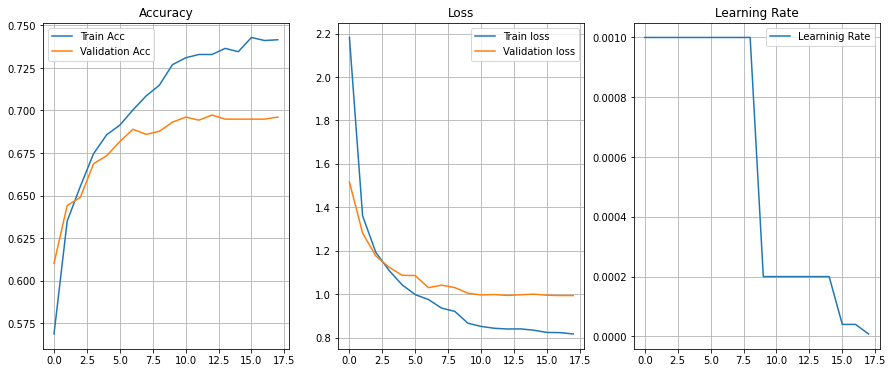

In [67]:
fig = plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
#print("\n Data set : "+D+" & "+T+";  No of Output Groups: "+str(Groups)+" ; GloVe vector used : "+glv+"; Attention :"+attention1)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(history.history['lr'], label='Learninig Rate')
plt.title("Learning Rate")
plt.legend()
plt.grid()


plt.show()